# Bonus: CAPM 

In [1]:
import yfinance as yf
import pandas as pd 

Importing Stock Data from Yahoo Finance 

In [13]:
import warnings
warnings.filterwarnings("ignore")


def Data(Ticker, Sdate, Edate):
    tick = yf.Ticker(Ticker)
    hist_data =  tick.history(start = Sdate, end = Edate)
    hist_data['Volume'] = hist_data['Volume']/1e5
    hist_data['Returns'] = hist_data['Close'].pct_change()
    hist_data = hist_data[hist_data['Returns'].notna()]
    hist_data.reset_index(inplace = True)
    hist_data.rename(columns = {'index':'Date'}, inplace = True)
    hist_data['Date'] = hist_data['Date'].dt.strftime('%Y/%m/%d')
    hist_data['Date'] = pd.to_datetime(hist_data['Date']) 
    hist_data['Ticker'] = Ticker
    return hist_data


Tick = ['MSFT', 'AAPL', 'AMZN', 'NVDA' , 'META', 'AMD', 'ADBE', 'ORCL', 'AVGO', 'DELL', 'SMCI', 'UBER', '^GSPC', '^NDX']
SDate = '2019-01-01'
EDate = '2024-07-31'


Dataset = []
for i in range(len(Tick)):Dataset.append(Data(Tick[i], SDate, EDate))
Stock_Data = pd.concat(Dataset)
Stock_Data.dropna(inplace = True)
Stock_Data.to_excel('StockData.xlsx')

Groupby Company: Find Descriptive Statistics of Returns, and Plot.

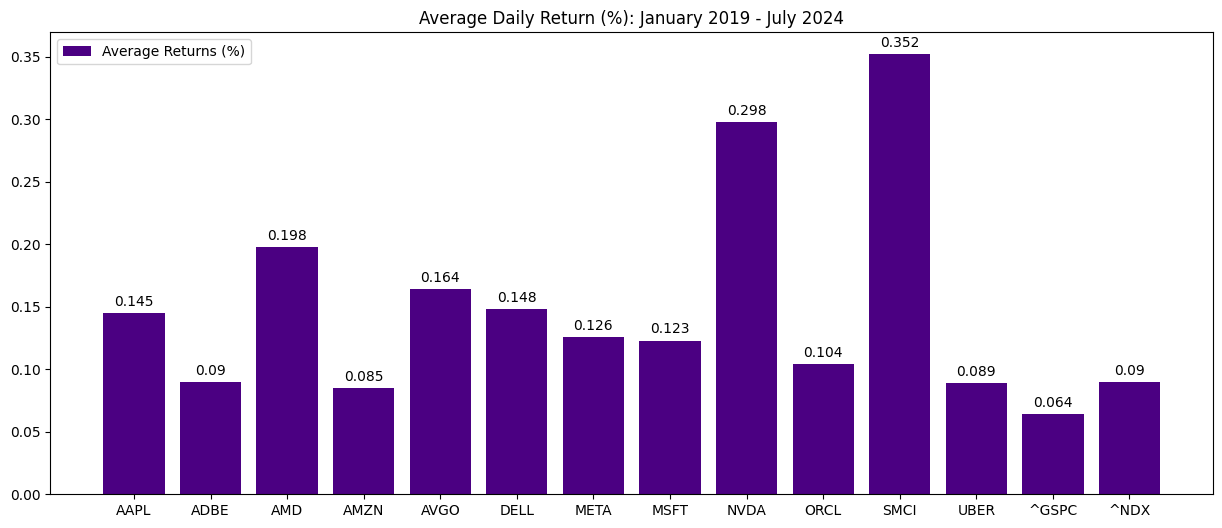

In [12]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd 
Stock_Data = pd.read_excel('StockData.xlsx')


Summary_Returns = Stock_Data['Returns'].describe() #Give summary statistics of returns over all stocks.

#Find Descriptive statistics of Returns using Groupby. 
GB_Ticker = Stock_Data[['Ticker', 'Returns']].groupby(by = 'Ticker') 
#Select only the Ticker and Returns columns, and then groupby 'Ticker'.
GB_Summary_Returns = GB_Ticker.describe() #Find Summary Statistics of Returns by Ticker


import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15, 6))
bar = ax.bar(GB_Summary_Returns.index, round(GB_Summary_Returns.Returns['mean']*100, 3), color = 'indigo', label = 'Average Returns (%)')
#Need to call Returns (variable of grouping), and then the mean from the summary statistics DataFrame (GB_Summary_Returns)
    #Multiplied by 100 to represent mean in % (and round to 3 decimals for label presentations)
#summary statistics DataFrame (GB_Summary_Returns) index = Ticker Name
ax.bar_label(bar, padding =3)
ax.set_title('Average Daily Return (%): January 2019 - July 2024')
ax.legend(loc=2)

Plotting min and max returns for each stock

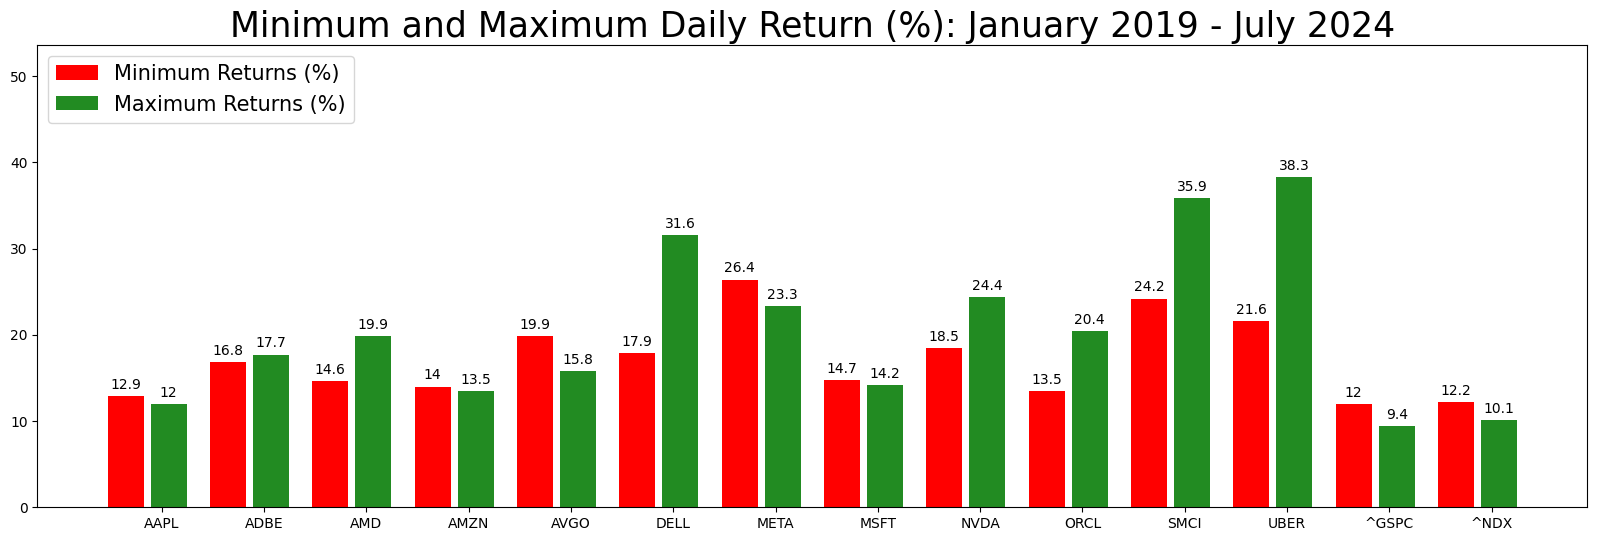

In [11]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np


MinMax = GB_Summary_Returns.Returns[['min', 'max']]
X_axis = np.arange(len(MinMax.index)) #For Label Locations
width = 0.35 #bar width 
multiplier = 0

color = ['red', 'forestgreen']
Labels = ['Minimum Returns (%)', 'Maximum Returns (%)']

fig, ax = plt.subplots(figsize = (20, 6))
for i in range(len(MinMax.columns)):  #index for i starts from 2 (Coeff index 2 == Mft-Rf)
    offset = width * multiplier #distance between the bars, on the same x-axis label location
    bar = ax.bar(X_axis + offset, round(MinMax[MinMax.columns[i]].abs() *100, 1),  width, label = Labels[i], color = color[i]) #color index start from 0, hence i-2
    ax.bar_label(bar, padding =3)
    multiplier +=1.2
ax.set_title('Minimum and Maximum Daily Return (%): January 2019 - July 2024', fontsize =25)
ax.set_xticks(X_axis + width,MinMax.index) #rename x-axis labels
ax.set_ylim([0, MinMax.max()[1]*100*1.4])  #Set Y-axis limit to max value from MinMax * 100 * 1.4 (better represenation)
ax.legend(loc=2, prop = {'size':15})
plt.show()

Running CAPM for each stock and plotting Beta

In [7]:
import yfinance as yf
import pandas as pd 
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt


#Importing Stock Data from Yahoo Finance 
def Data(Ticker, Market_Tick, Rate_Tick, Sdate, Edate):
    tick = yf.Ticker(Ticker)
    hist_data =  tick.history(start = Sdate, end = Edate)
    hist_data['Volume'] = hist_data['Volume']/1e5
    hist_data['Returns'] = hist_data['Close'].pct_change()
    hist_data = hist_data[hist_data['Returns'].notna()]
    hist_data.reset_index(inplace = True)
    hist_data.rename(columns = {'index':'Date'}, inplace = True)
    hist_data['Date'] = hist_data['Date'].dt.strftime('%Y/%m/%d')
    hist_data['Date'] = pd.to_datetime(hist_data['Date']) 
    hist_data['Ticker'] = Ticker
    hist_data = hist_data[['Date', 'Returns', 'Ticker']]

    market_tick = yf.Ticker(Market_Tick)
    market_data = market_tick.history(start = Sdate, end = Edate)
    market_data.reset_index(inplace = True)
    market_data.rename(columns = {'index':'Date'}, inplace = True)
    market_data['Date'] = market_data['Date'].dt.strftime('%Y/%m/%d')
    market_data['Date'] = pd.to_datetime(market_data['Date'])
    market_data['Market_Returns'] = market_data['Close'].pct_change()
    market_data = market_data[market_data['Market_Returns'].notna()]
    market_data = market_data[['Date','Market_Returns']]
    hist_data = pd.merge(left = hist_data, right = market_data, left_on  = 'Date', right_on = 'Date')
    
    rf_tick = yf.Ticker(Rate_Tick)
    rf_data = rf_tick.history(start = Sdate, end = Edate)
    rf_data.reset_index(inplace = True)
    rf_data.rename(columns = {'index':'Date'}, inplace = True)
    rf_data['Date'] = rf_data['Date'].dt.strftime('%Y/%m/%d')
    rf_data['Date'] = pd.to_datetime(rf_data['Date'])
    rf_data['Rf_Rate'] = rf_data['Close']/100
    rf_data = rf_data[['Date', 'Rf_Rate']]
    hist_data = pd.merge(left = hist_data, right = rf_data, left_on  = 'Date', right_on = 'Date')
    hist_data['R-rf'] = hist_data['Returns'] - hist_data['Rf_Rate']
    hist_data['Rm-rf'] = hist_data['Market_Returns']  - hist_data['Rf_Rate']
    return hist_data

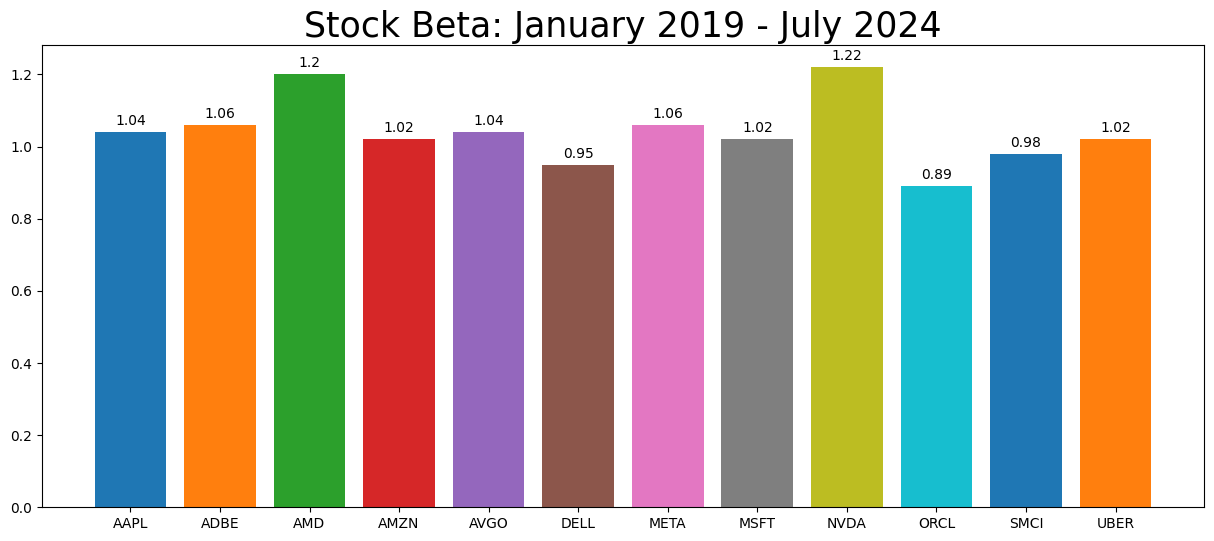

In [ ]:


Tick = ['MSFT', 'AAPL', 'AMZN', 'NVDA' , 'META', 'AMD', 'ADBE', 'ORCL', 'AVGO', 'DELL', 'SMCI', 'UBER']
Market_Tick = '^NDX'
Rate_Tick = '^IRX'
SDate = '2019-01-01'
EDate = '2024-07-31'

CAPM_Data = []
for i in range(len(Tick)): CAPM_Data.append(Data(Tick[i], Market_Tick, Rate_Tick, SDate, EDate))
CAPM_Data = pd.concat(CAPM_Data)
CAPM_Data.to_excel('CAPM_Data.xlsx')


GB_CAPM_Data = CAPM_Data.groupby(by = 'Ticker')
Beta = []
fig, ax = plt.subplots(figsize = (15, 6))  
for tick in GB_CAPM_Data.groups.keys():
    df = GB_CAPM_Data.get_group(tick)
    Y = df['R-rf'] 
    X = df['Rm-rf']
    X = sm.add_constant(X)
    regression_model = sm.OLS(Y, X)
    results = regression_model.fit()
    beta = results.params.copy()[1]
    bar = ax.bar(tick, round(beta, 2)) 
    ax.bar_label(bar, padding =3)
ax.set_title('Stock Beta: January 2019 - July 2024', fontsize =25)
plt.savefig('GB_CAPM_Beta.png')

Find Stock Betas in each year: Groupby Ticker and then Year

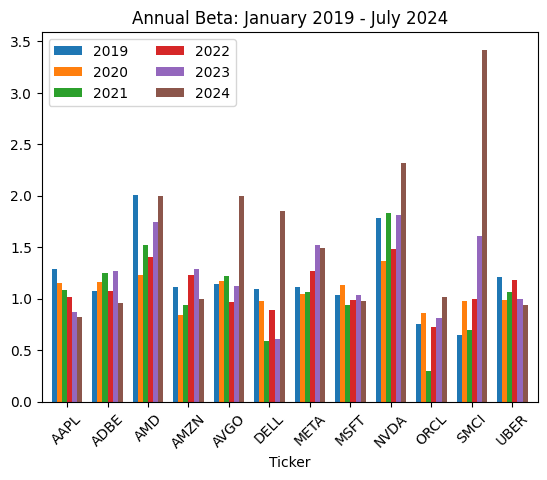

In [10]:
import warnings
warnings.filterwarnings("ignore")


import yfinance as yf
import pandas as pd 
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import datetime

CAPM_Data = pd.read_excel('CAPM_Data.xlsx')

CAPM_Data['Year'] = CAPM_Data['Date'].dt.year #dt helps working with datetime series 

GB_CAPM_Data = CAPM_Data.groupby(by = ['Ticker', 'Year'])

#Summary Statistics of Stock Returns, for each year.
GB_CAPM_Data_Returns_Summary = GB_CAPM_Data['Returns'].describe() 

Year = ['2019', '2020', '2021', '2022', '2023', '2024']
color = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']


Beta = []
for tick in GB_CAPM_Data.groups.keys():
    df = GB_CAPM_Data.get_group(tick)
    Y = df['R-rf'] 
    X = df['Rm-rf']
    X = sm.add_constant(X)
    regression_model = sm.OLS(Y, X)
    results = regression_model.fit()
    beta = results.params.copy()[1]
    Beta_DF = pd.DataFrame([tick[0], tick[1], beta]).T
    Beta_DF.rename(columns = {0:'Ticker', 1:'Year', 2:'Beta'}, inplace = True) #For storing betas in Dataframes
    Beta.append(Beta_DF)

Beta_Data = pd.concat(Beta)
Beta_Data = Beta_Data.set_index(['Ticker', 'Year']).Beta  #Multi-Index: Tickers and Year for each Beta value
Beta_Data_Unstacked = Beta_Data.unstack() #Unstacks data (Beta revealed in a grid, with each axes representing an index)


Beta_Data_Unstacked.plot(kind='bar', width = 0.75)
plt.title('Annual Beta: January 2019 - July 2024')
plt.tick_params(axis='x', rotation=45)
plt.legend(loc=2, ncol = 2, prop={'size': 10})
plt.savefig('GB_CAPM_Beta_Annual.png')